In [2]:
import pandas as pd
import numpy as np

import gc 

import sklearn as skl
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

import category_encoders as ce

import xgboost as xgb
from xgboost.sklearn import XGBClassifier

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Importing data

We first import data from previoulsy modify data set using featuretools
see https://www.kaggle.com/willkoehrsen/automated-feature-engineering-basics/notebook
the list of important features comes from lgbm analysis

In [3]:
#important_features = pd.read_csv('csv_files/important_features.csv')
training_set = pd.read_csv('csv_files/feature_matrix_spec_train.csv',nrows=8000)
test_set = pd.read_csv('csv_files/feature_matrix_spec_test.csv')

In [4]:
training_set = training_set.drop(columns=["set"],axis=1)
test_set = test_set.drop(columns=['set'],axis=1)

# Shaping data

In [5]:
def missing_data(data) :
    """compute the number and the percentage of missing values per columns"""
    nb_missing_values = data.isnull().sum().sort_values(ascending = False) #count the number of missing values
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False) #percentage of missing values
    return pd.concat([nb_missing_values, percent], axis=1, keys=['total' , 'Percent'])

In [6]:
def one_hot_encoding(data):
    """Transform object variables using get_dummies function"""
    obj_variables = [col for col in data if data[col].dtype=='object']
    data = pd.get_dummies(data=data, columns = obj_variables, dummy_na=True)
    print( str(len(obj_variables))+ ' object features have been modified')
    return data

In [7]:
def missing_features(data1,data2):
    """spot features (columns) present in data1 and not in data2"""
    diff_features = []
    
    for col in data1:
        present=0
        for col2 in data2:
            if col == col2:
                present=1
        if present == 0 :
            diff_features.append(col)
    return(diff_features)

In [8]:
def xgb_training_routine(data,k_folds) :
    
    #variables to store the results:
    acc = 0 #accuracy on validation set
    val_pred=np.zeros(data.shape[0])
    
    #generate folds to split data into training and validation_set :
    folds = StratifiedKFold(n_splits=k_folds,shuffle=True,random_state=2018)
    
    fold_number = 0
    for train_index, val_index in folds.split(training_set.drop(['SK_ID_CURR','TARGET'],axis=1), training_set[['TARGET']]):
        fold_number+=1
        print('############# process fold '+str(fold_number)+' #############')
        #split data set
        train_set = training_set.drop(['SK_ID_CURR','TARGET'],axis=1).iloc[train_index]
        train_target = training_set[['TARGET']].iloc[train_index]
        val_set = training_set.drop(['SK_ID_CURR','TARGET'],axis=1).iloc[val_index]
        val_target = training_set[['TARGET']].iloc[val_index]
        
        #define classifier
        xgb_clf = XGBClassifier(learning_rate =0.01, n_estimators=10000, max_depth=4, min_child_weight=5, 
                                subsample=0.8, colsample_bytree=0.8, objective= 'binary:logistic', 
                                nthread=4, scale_pos_weight=2.5, seed=27, reg_lambda = 1.2)
        
        #fiting the classifier
        xgb_clf.fit(train_set,train_target,eval_set=[(val_set,val_target)],
                    eval_metric='auc',early_stopping_rounds=100,verbose=100)
        
        #predictions on validation set
        val_pred[val_index] = xgb_clf.predict_proba(val_set)[:, 1]
        
        #accuracy on validation set
        new_acc = roc_auc_score(val_target, val_pred[val_index])
        print('Fold %2d AUC : %.6f' % (fold_number, new_acc))
        
        if new_acc>acc :
            acc = new_acc
            best_clf = xgb_clf #keep the best classifier
        reg_clf = xgb_clf
        
        del train_set,train_target,val_set,val_target,xgb_clf
        
    return(best_clf,reg_clf)

## Processing

In [9]:
#one hot encoding
training_set = one_hot_encoding(training_set)
test_set = one_hot_encoding(test_set)

41 object features have been modified
41 object features have been modified


In [10]:
#spot columns present in training set and not in test set

diff_features_train = missing_features(training_set,test_set)
print('the folowing features have been removed from training set :')
print(diff_features_train)

#remove missing columns
training_set = training_set.drop(diff_features_train, axis=1)

#spot columns present in test set and not in training set

diff_features_test = missing_features(test_set,training_set)
print('the folowing features have been removed from test set :')
print(diff_features_test)

#remove missing columns
test_set = test_set.drop(diff_features_test, axis = 1)

the folowing features have been removed from training set :
[]
the folowing features have been removed from test set :
['NAME_INCOME_TYPE_Businessman', 'NAME_INCOME_TYPE_Student', 'MODE(bureau.CREDIT_ACTIVE)_Bad debt', 'MODE(previous_app.NAME_GOODS_CATEGORY)_Additional Service', 'MODE(previous_app.CODE_REJECT_REASON)_SYSTEM', 'MODE(bureau.CREDIT_TYPE)_Cash loan (non-earmarked)', 'MODE(bureau.CREDIT_TYPE)_Loan for working capital replenishment', 'MODE(bureau.CREDIT_TYPE)_Unknown type of loan', 'MODE(cash.NAME_CONTRACT_STATUS)_Approved', 'MODE(previous_app.NAME_CASH_LOAN_PURPOSE)_Gasification / water supply', 'MODE(previous_app.NAME_CASH_LOAN_PURPOSE)_Hobby', 'MODE(previous_app.NAME_CASH_LOAN_PURPOSE)_Journey', 'MODE(previous_app.MODE(cash.NAME_CONTRACT_STATUS))_Demand']


In [11]:
best_clf, reg_clf = xgb_training_routine(training_set,4)

############# process fold 1 #############


/home/taboga/virtualenvs/env1/lib/python3.5/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/taboga/virtualenvs/env1/lib/python3.5/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0]	validation_0-auc:0.685769
Will train until validation_0-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.747527
[200]	validation_0-auc:0.756335
[300]	validation_0-auc:0.760742
[400]	validation_0-auc:0.762646
[500]	validation_0-auc:0.765844
[600]	validation_0-auc:0.765869
Stopping. Best iteration:
[536]	validation_0-auc:0.767424

Fold  1 AUC : 0.766491
############# process fold 2 #############


/home/taboga/virtualenvs/env1/lib/python3.5/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/taboga/virtualenvs/env1/lib/python3.5/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0]	validation_0-auc:0.623578
Will train until validation_0-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.725765
[200]	validation_0-auc:0.741135
[300]	validation_0-auc:0.750425
[400]	validation_0-auc:0.7558
[500]	validation_0-auc:0.755912
[600]	validation_0-auc:0.756446
Stopping. Best iteration:
[557]	validation_0-auc:0.756985

Fold  2 AUC : 0.755961
############# process fold 3 #############


/home/taboga/virtualenvs/env1/lib/python3.5/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/taboga/virtualenvs/env1/lib/python3.5/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0]	validation_0-auc:0.69181
Will train until validation_0-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.745792
[200]	validation_0-auc:0.746827
[300]	validation_0-auc:0.749699
[400]	validation_0-auc:0.755429
[500]	validation_0-auc:0.754943
Stopping. Best iteration:
[439]	validation_0-auc:0.755999

Fold  3 AUC : 0.754683
############# process fold 4 #############


/home/taboga/virtualenvs/env1/lib/python3.5/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/taboga/virtualenvs/env1/lib/python3.5/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0]	validation_0-auc:0.673121
Will train until validation_0-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.747661
[200]	validation_0-auc:0.758114
[300]	validation_0-auc:0.759448
[400]	validation_0-auc:0.76283
[500]	validation_0-auc:0.765649
[600]	validation_0-auc:0.766125
Stopping. Best iteration:
[598]	validation_0-auc:0.766128

Fold  4 AUC : 0.764995


## Predictions

In [12]:
pred_proba = best_clf.predict_proba(test_set.drop(['TARGET','SK_ID_CURR'],axis=1))

In [13]:
result_bc = pd.DataFrame({'SK_ID_CURR' : test_set['SK_ID_CURR'],'TARGET' : [row[1] for row in pred_proba]})

In [15]:
result_bc.to_csv('results_bc.csv',index=False)

In [16]:
pred_proba_2 = reg_clf.predict_proba(test_set.drop(['TARGET','SK_ID_CURR'],axis=1))

In [17]:
result_reg = pd.DataFrame({'SK_ID_CURR' : test_set['SK_ID_CURR'],'TARGET' : [row[1] for row in pred_proba_2]})

In [18]:
result_reg.to_csv('results_reg.csv',index=False)

# Features analysis

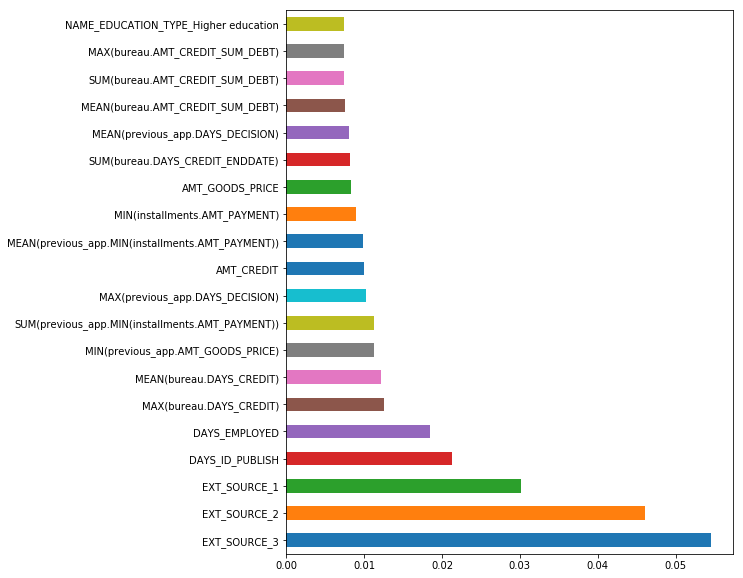

In [20]:
feat_imp = pd.Series(best_clf.feature_importances_, index = training_set.drop(['SK_ID_CURR','TARGET'],axis = 1).columns)
feat_imp.nlargest(20).plot(kind = 'barh' , figsize=(8,10))